In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
import scipy
import math
import gseapy as gp

from scipy import stats
from statsmodels.stats import multitest
from statsmodels.stats.multicomp import pairwise_tukeyhsd
colormap = 'colorblind'
colors = sns.color_palette(colormap, 8)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 12, 'axes.titlesize':'medium',})
from scipy.stats import gaussian_kde
import datashader as ds
from datashader.mpl_ext import dsshow

def using_datashader(ax, x, y, vmax):

    df = pd.DataFrame(dict(x=x, y=y))
    dsartist = dsshow(
        df,
        ds.Point("x", "y"),
        ds.count(),
        vmin=0,
        vmax=vmax,
        norm="linear",
        aspect="auto",
        ax=ax, rasterized=True, width_scale=0.5, height_scale=0.5
    )


    
    plt.colorbar(dsartist)

# Assess reproducibility of MAGECK results.

Load in both larger and smaller datasets. Will mostly focus on larger, but use smaller to ascertain reproducibility metrics.

In [2]:
primaryData = pd.read_csv('Results/mageckResults.gene_summary.txt', sep='\t')
secondaryData = pd.read_csv('Results/mageckInputSecondary.gene_summary.txt', sep='\t')

If a gene has a predicted positive effect in our secondary screen, does it in our primary? Negative negative?

(0.0, 1.0)

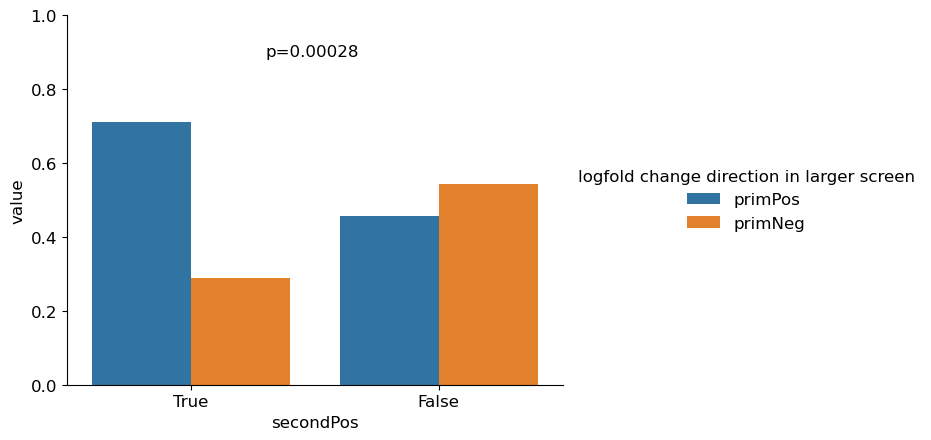

In [3]:
graph = pd.merge(primaryData, secondaryData, on = 'id', how='inner', suffixes = ('_prim','_second'))
#no data are == 0 so we don't have to solve for that case
graph['primPos'] = graph['pos|lfc_prim'] > 0
graph['secondPos'] = graph['pos|lfc_second'] > 0
contingency = pd.crosstab(graph.primPos, graph.secondPos)
stat = scipy.stats.fisher_exact(contingency)[1]
graph = graph.groupby(['secondPos']).primPos.mean().reset_index()
graph['primNeg'] = 1- graph.primPos
graph = graph.melt(id_vars = 'secondPos', value_vars = ['primPos','primNeg'])
ax = sns.barplot(x= 'secondPos', y='value', hue='variable', data=graph, hue_order=['primPos','primNeg'], order=[True,False])
sns.despine()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title='logfold change direction in larger screen')
ax.text(0.4, 0.9, 'p=' + str(round(stat,5)), va='center', rotation = 'horizontal', transform=ax.transAxes)
plt.ylim(0,1)

Does this improve if we restrict to the top and bottom 22 ranked? (top and bottom 10% of genes in secondary screen)

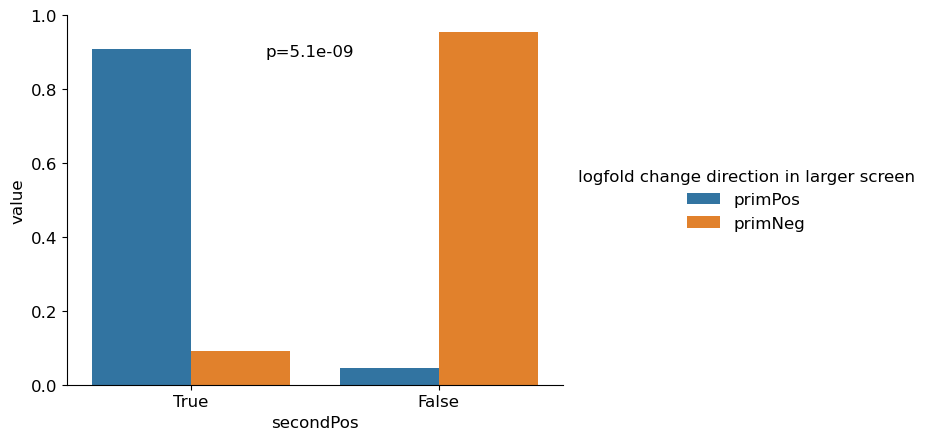

In [23]:
restricted = secondaryData.loc[(secondaryData['neg|rank'] <= 22) | (secondaryData['pos|rank'] <= 22),]
graph = pd.merge(primaryData, restricted, on = 'id', how='inner', suffixes = ('_prim','_second'))

graph['primPos'] = graph['pos|lfc_prim'] > 0
graph['secondPos'] = graph['pos|lfc_second'] > 0
contingency = pd.crosstab(graph.primPos, graph.secondPos)
stat = scipy.stats.fisher_exact(contingency)[1]
graph = graph.groupby(['secondPos']).primPos.mean().reset_index()
graph['primNeg'] = 1- graph.primPos
graph = graph.melt(id_vars = 'secondPos', value_vars = ['primPos','primNeg'])
ax = sns.barplot(x= 'secondPos', y='value', hue='variable', data=graph, hue_order=['primPos','primNeg'], order=[True,False])
sns.despine()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title='logfold change direction in larger screen')
ax.text(0.4, 0.9, 'p=' + str(round(stat,10)), va='center', rotation = 'horizontal', transform=ax.transAxes)
plt.ylim(0,1)
plt.savefig('Figures/replicabilityFishers.pdf')

Load in some gene sets to contextualize the work.

In [1]:
#Infection is required for interferon induction.
#Here we list genes we expect to be required for flu infection based on a screen performed by Li et al.
#(https://doi.org/10.1038/s41467-019-13965-x)

#list of 121 essential flu genes
essential = ["AARS","ACTB","AFG3L2","ALG2","ANKLE2","ATP6AP1","ATP6AP2",
 "ATP6V0B","ATP6V0C","ATP6V0D1","ATP6V1A","ATP6V1B2","ATP6V1C1","ATP6V1D",
 "ATP6V1E1","ATP6V1F","ATP6V1G1","ATP6V1H","BET1","BRF2","CCDC115","CCT4","CDK1",
 "CHMP6","CMTR1","COG1","COG2","COG3","COG4","COG8","COPA","COPG1","CSE1L","DAD1",
 "DBR1","DPAGT1","DYRK1A","EEF2", "EIF2B4","ENY2","EXOC2","EXOC3","EXOC4","FAM25A","GGPS1",
 "GOSR2","HAUS8","MBTPS1","MCM3AP","MYH9","NCBP2","NSF","NUDT21","NUP153","NUP85","NXF1",
 "PAXBP1","PCID2","PKD1","PLA2G10","PLLP","POLE2","POLR3A","POLR3H","POP7","PREB","RABGGTA",
 "RABGGTB","RARS2","RCC1","RNASEK","RPL6","RPLP0","RPN1","RPN2","RRP12","SARS","SART3","SCAP",
 "SCFD1","SCRT1","SEC13","SEC16A","SEZ6L","SFPQ","SFSWAP","SLC26A10","SLC35A1","SLC39A7","SMARCB1",
 "SNX18","SOCS3","SPCS3","SRP14","SRP19","SRP54","SRP9","SRPRB","SRRT","SYS1","TBP","TMEM199","TMEM258",
 "TMEM38A","TOP2A","TPR","TRAPPC1","TRAPPC11","TRAPPC3","TRAPPC4","TRAPPC5","TRAPPC8","TTC27",
 "TUBGCP2","TWISTNB","VHL","VPS13D","VPS54","WDR7","YKT6","ZSCAN20"]

#entry:
#includes endocytosis (V-type ATPase), sialic acid production, COP-1 pathway
entry = ["ATP6AP1","ATP6AP2", "ATP6V0B","ATP6V0C","ATP6V0D1","ATP6V1A","ATP6V1B2","ATP6V1C1","ATP6V1D",
              "ATP6V1E1", "ATP6V1F","ATP6V1G1","ATP6V1H", "CHMP6",'SLC35A1', 'WDR7', 'CCDC115','TMEM199', 
             'COPG1','COPA','RABGGTA','RABGGTB','GGPS1','VPS54']

#replication:
#nuclear import, viral transcription, nuclear export, CMTR1 (shown in that study to be important for cap-snatching)
replication = ['NUP85', 'NUP153', 'TPR', 'RCC1', 'POLE2', 'TWISTNB', 'NXF1', 'ANKLE2', 'CMTR1']


core_ifn = ['RNF135','DDX58','MAVS','IKBKG','IRF3','IRF7']

#from https://www.gsea-msigdb.org/gsea/msigdb/cards/GOBP_RIG_I_SIGNALING_PATHWAY adding in missing elements.
extended_ifn = ["PHB2","PUM2","DDX58","ANKRD17","LSM14A","GLTSCR2","BIRC2","BIRC3","USP17L2","OAS3","PHB","RNF125","DDX60","NPLOC4","GPATCH3","SEC14L1","C1QBP","UFD1L","TRIM25",
"DHX58","NLRX1","CLPB","RNF135","ZCCHC3","OASL","TRIM15","PUM1","USP15", 'MAVS', 'TRAF3','IKBKG', 'TANK','AZI2', 'TBKBP1','IKBKE','IRF3','IRF7']

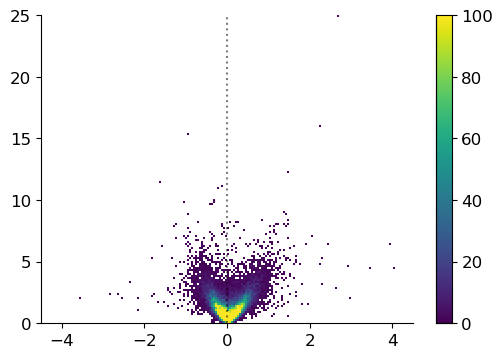

In [17]:


fig, ax = plt.subplots(figsize=(6,4), ncols =1)
primaryData['higherScore'] = -np.log10(primaryData[['neg|score']])
primaryData.loc[primaryData['pos|lfc'] > 0, 'higherScore'] = -np.log10(primaryData['pos|score'])
using_datashader(ax, primaryData['pos|lfc'],primaryData['higherScore'], 100)
plt.sca(ax)
sns.despine()
plt.ylim(0,25)
plt.xlim(-4.5,4.5)
ax.axvline(x=0, color='k', linestyle=':',alpha=0.5)
plt.savefig('Figures/MageckDistribution.pdf', format='pdf')


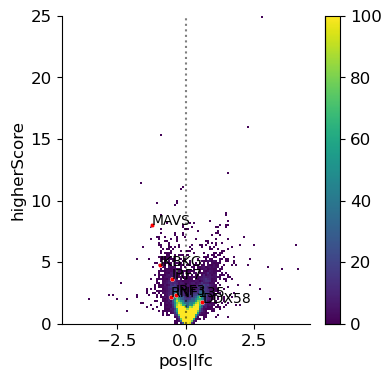

In [15]:
fig, ax = plt.subplots(figsize=(4,4), ncols =1)

#primaryData['higherScore'] = -np.log10(primaryData[['neg|score', 'pos|score']].min(axis=1))
using_datashader(ax, primaryData['pos|lfc'],primaryData['higherScore'], 100)
plt.sca(ax)
sns.despine()
plt.ylim(0,25)
plt.xlim(-4.5,4.5)
ax.axvline(x=0, color='k', linestyle=':',alpha=0.5)

sns.scatterplot(data = primaryData[primaryData.id.isin(core_ifn)], x='pos|lfc', y='higherScore', color='red', s=10, ax=ax)
for gene in core_ifn:
    currFrame = primaryData[primaryData.id == gene]
    ax.text(currFrame['pos|lfc'].iloc[0], currFrame['higherScore'].iloc[0], gene, fontsize=10)
plt.savefig('Figures/RIG.pdf', format='pdf')


Generating a colormap of rankings to map onto illustrator file.

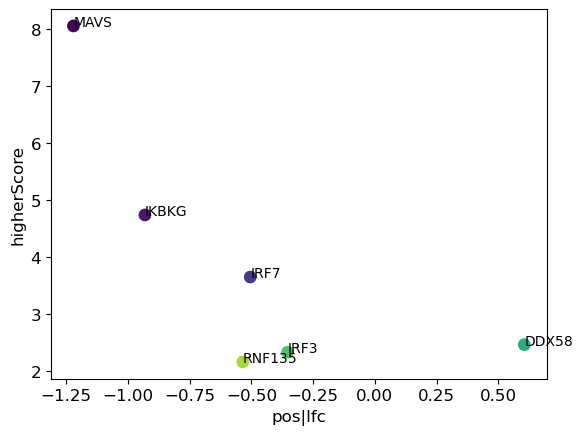

In [6]:
ax = sns.scatterplot(data = primaryData[primaryData.id.isin(core_ifn)], x='pos|lfc', y='higherScore', c=primaryData[primaryData.id.isin(core_ifn)]['neg|rank'],cmap='viridis', s=100, vmin=0, vmax=2000)
for gene in core_ifn:
    currFrame = primaryData[primaryData.id == gene]
    ax.text(currFrame['pos|lfc'].iloc[0], currFrame['higherScore'].iloc[0], gene, fontsize=10)
plt.savefig('Figures/colors_for_diagram.pdf')

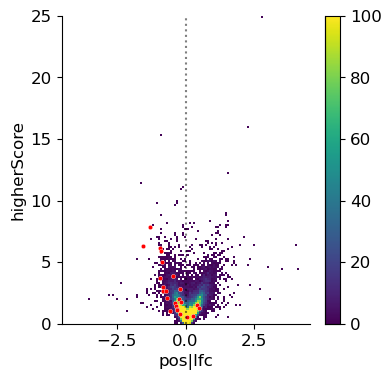

In [16]:
fig, ax = plt.subplots(figsize=(4,4), ncols =1)

using_datashader(ax, primaryData['pos|lfc'],primaryData['higherScore'], 100)
plt.sca(ax)
sns.despine()
plt.ylim(0,25)
plt.xlim(-4.5,4.5)
ax.axvline(x=0, color='k', linestyle=':',alpha=0.5)
sns.scatterplot(data = primaryData[primaryData.id.isin(entry)], x='pos|lfc', y='higherScore', color='red', s=10, ax=ax)

plt.savefig('Figures/fluReqMageck.pdf', format='pdf')


And some gene set enrichment analysis

In [7]:
gene_sets = {'RIG_I':extended_ifn, 'essential':essential, 'entry':entry}

test = primaryData.copy()
test['rank'] = -np.log10(test['neg|score'])
gsData = gp.prerank(rnk=test[['id','rank']].set_index('id'), gene_sets=gene_sets, permutation_num=1000, outdir='Results/gsea_output')
gsData.res2d


2025-05-14 17:19:44,602 [WARNING] Duplicated values found in preranked stats: 8.66% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,entry,0.737107,1.675748,0.0,0.0,0.0,15/24,13.90%,ATP6AP1;ATP6V0C;CCDC115;ATP6V1B2;WDR7;ATP6V0B;...
1,prerank,RIG_I,0.601627,1.433716,0.005,0.006002,0.012,12/37,10.34%,MAVS;ZCCHC3;IKBKG;GLTSCR2;IRF7;USP17L2;BIRC2;D...
2,prerank,essential,0.535361,1.360843,0.0,0.01934,0.057,67/121,30.68%,ATP6AP1;NUDT21;ATP6V0C;CCDC115;ATP6V1B2;PCID2;...


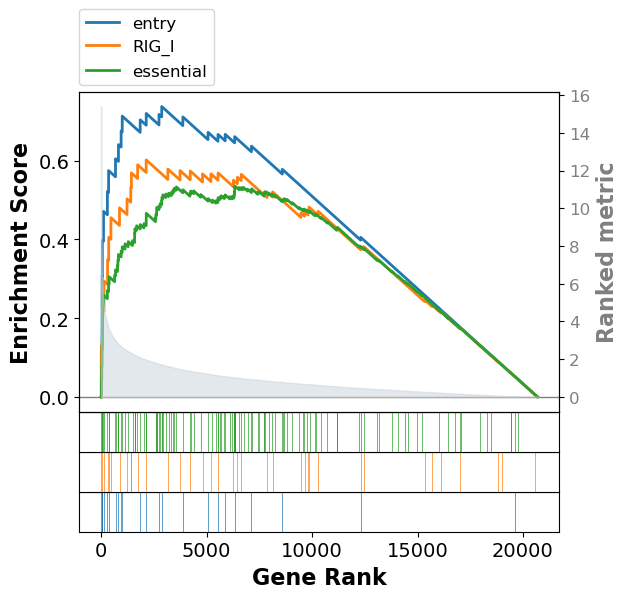

In [8]:
axs = gsData.plot(terms=gsData.res2d.Term,
                   #legend_kws={'loc': (1.2, 0)}, # set the legend loc
                   show_ranking=True, # whether to show the second yaxis
                   figsize=(3,4)
                  )

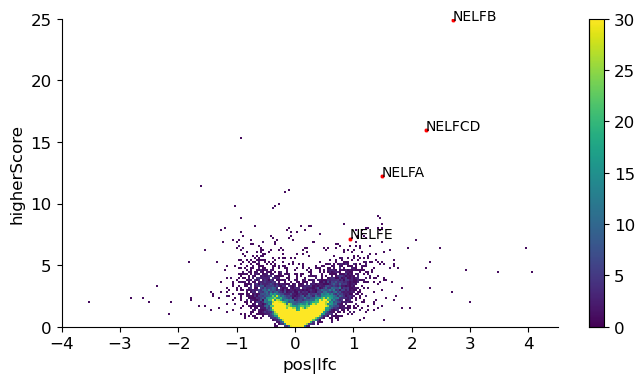

In [18]:
fig, ax = plt.subplots(figsize=(8,4), ncols =1)
genesTested = ['NELFB','NELFCD','NELFA','NELFE']
using_datashader(ax, primaryData['pos|lfc'],primaryData['higherScore'], 30)
plt.sca(ax)
sns.despine()
plt.ylim(0,25)
plt.xlim(-4,4.5)
sns.scatterplot(data = primaryData[primaryData.id.isin(genesTested)], x='pos|lfc', y='higherScore', color='red', s=10, ax=ax)
for gene in genesTested:
    currFrame = primaryData[primaryData.id == gene]
    ax.text(currFrame['pos|lfc'].iloc[0], currFrame['higherScore'].iloc[0], gene, fontsize=10)


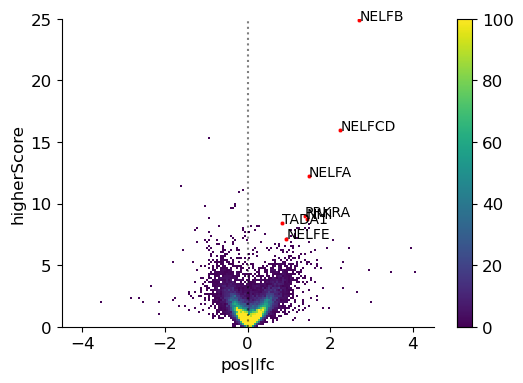

In [19]:
fig, ax = plt.subplots(figsize=(6,4), ncols =1)
genesTested = primaryData[primaryData['pos|rank'] < 7].id.tolist() + ['NELFE']

using_datashader(ax, primaryData['pos|lfc'],primaryData['higherScore'], 100)
plt.sca(ax)
sns.despine()
plt.ylim(0,25)
plt.xlim(-4.5,4.5)
ax.axvline(x=0, color='k', linestyle=':',alpha=0.5)
sns.scatterplot(data = primaryData[primaryData.id.isin(genesTested)], x='pos|lfc', y='higherScore', color='red', s=10, ax=ax)


for gene in genesTested:
    currFrame = primaryData[primaryData.id == gene]
    ax.text(currFrame['pos|lfc'].iloc[0], currFrame['higherScore'].iloc[0], gene, fontsize=10)
plt.savefig('Figures/positiveSelectionMAGECK.pdf')

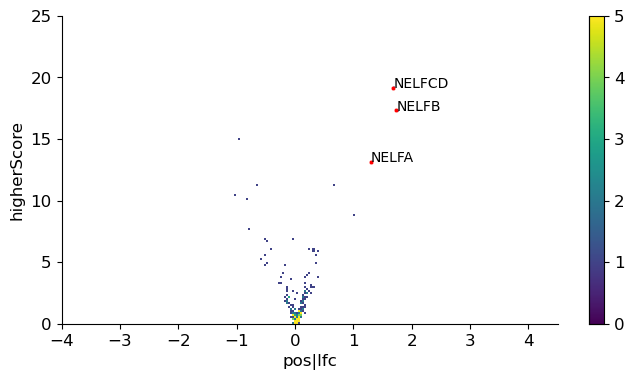

In [22]:
fig, ax = plt.subplots(figsize=(8,4), ncols =1)
genesTested = secondaryData[secondaryData['pos|rank'] < 4].id.tolist()
secondaryData['higherScore'] = -np.log10(secondaryData[['neg|score']])
secondaryData.loc[secondaryData['pos|lfc'] > 0, 'higherScore'] = -np.log10(secondaryData['pos|score'])
using_datashader(ax, secondaryData['pos|lfc'],secondaryData['higherScore'], 5)
plt.sca(ax)
sns.despine()
plt.ylim(0,25)
plt.xlim(-4,4.5)
sns.scatterplot(data = secondaryData[secondaryData.id.isin(genesTested)], x='pos|lfc', y='higherScore', color='red', s=10, ax=ax)
for gene in genesTested:
    currFrame = secondaryData[secondaryData.id == gene]
    ax.text(currFrame['pos|lfc'].iloc[0], currFrame['higherScore'].iloc[0], gene, fontsize=10)
plt.savefig('Figures/secondary.pdf')

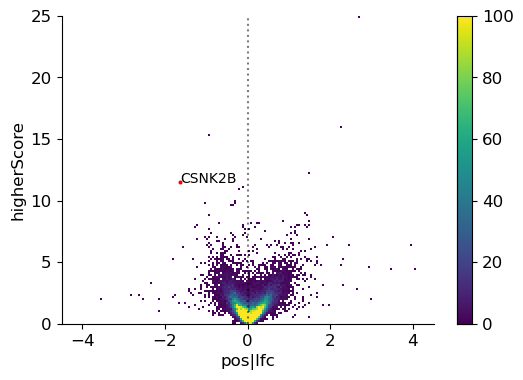

In [21]:
fig, ax = plt.subplots(figsize=(6,4), ncols =1)
genesTested = ['CSNK2B']

using_datashader(ax, primaryData['pos|lfc'],primaryData['higherScore'], 100)
plt.sca(ax)
sns.despine()
plt.ylim(0,25)
plt.xlim(-4.5,4.5)
ax.axvline(x=0, color='k', linestyle=':',alpha=0.5)
sns.scatterplot(data = primaryData[primaryData.id.isin(genesTested)], x='pos|lfc', y='higherScore', color='red', s=10, ax=ax)


for gene in genesTested:
    currFrame = primaryData[primaryData.id == gene]
    ax.text(currFrame['pos|lfc'].iloc[0], currFrame['higherScore'].iloc[0], gene, fontsize=10)
plt.savefig('Figures/CSNK2BMageck.pdf')

In [33]:
gRNA = pd.read_csv('Results/mageckResults.sgrna_summary.txt', sep='\t')


In [34]:
gRNA = gRNA.loc[gRNA.Gene == 'DDX58']
gRNA['sgrna'] = gRNA.sgrna.str.slice(0,-3)


/tmp/ipykernel_1464088/2303521439.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(y='LFC', x='sgrna', data=gRNA, palette = ['0.5'], edgecolor='0',
/tmp/ipykernel_1464088/2303521439.py:5: UserWarning: 
The palette list has fewer values (1) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.swarmplot(y='LFC', x='sgrna', data=gRNA, palette = ['0.5'], edgecolor='0',


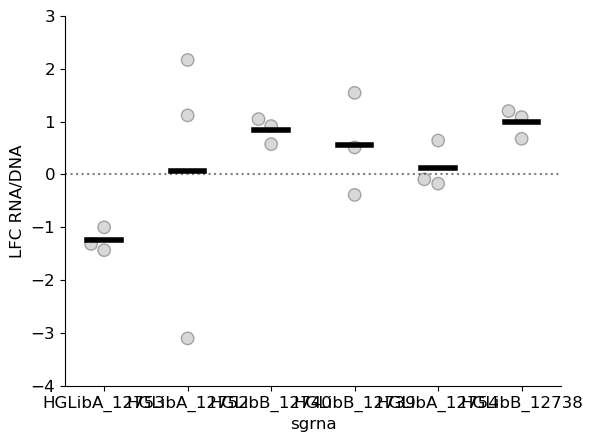

In [52]:
#order of guides in figure
order = ['HGLibA_12753','HGLibA_12752','HGLibB_12740', 'HGLibB_12739','HGLibA_12754','HGLibB_12738']
fig, ax = plt.subplots(1,1)

sns.swarmplot(y='LFC', x='sgrna', data=gRNA, palette = ['0.5'], edgecolor='0',        
                dodge=False, linewidth=1, s=9,   zorder=5, order=order, ax=ax, alpha=0.3)

sns.despine()
a = plt.ylabel('LFC RNA/DNA')

for position, val in enumerate(order):
    y = gRNA[gRNA.sgrna == val]['LFC'].mean()
    plt.plot([position-0.2, position+0.2], [y, y], lw=4, c='k', zorder=9)

plt.ylim(-4,3)
ax.axhline(y=0, color='k', linestyle=':',alpha=0.5)

plt.savefig('Figures/DDX58_pos.pdf', bbox_inches="tight")

In [41]:
gRNA

,sgrna,Gene,control_count,treatment_count,control_mean,treat_mean,LFC,control_var,adj_var,score,p.low,p.high,p.twosided,FDR,high_in_treatment
30186,HGLibB_12739,DDX58,39.2860,116.380,39.2860,116.380,1.542800,2971.600,371.7200,3.99850,0.999970,0.000033,0.000065,0.000773,True
32539,HGLibA_12753,DDX58,701.0700,280.510,701.0700,280.510,-1.318400,88436.000,11917.0000,3.85250,0.000058,0.999940,0.000117,0.001290,False
35753,HGLibA_12753,DDX58,547.2600,201.590,547.2600,201.590,-1.436300,59742.000,8836.0000,3.67730,0.000118,0.999880,0.000236,0.002370,False
40805,HGLibB_12738,DDX58,73.9530,171.030,73.9530,171.030,1.198600,4711.900,793.6500,3.44590,0.999710,0.000286,0.000572,0.005030,True
43517,HGLibB_12738,DDX58,99.0690,211.150,99.0690,211.150,1.084100,6281.300,1127.5000,3.33790,0.999580,0.000423,0.000845,0.006969,True
48639,HGLibA_12752,DDX58,1.7081,11.150,1.7081,11.150,2.165600,44.574,8.9363,3.15850,0.998890,0.001107,0.002215,0.015342,True
77666,HGLibB_12740,DDX58,53.0000,110.490,53.0000,110.490,1.045900,1652.800,532.1700,2.49230,0.993580,0.006416,0.012832,0.059186,True
78878,HGLibA_12752,DDX58,40.6740,89.335,40.6740,89.335,1.116100,1183.900,387.5200,2.47190,0.993150,0.006852,0.013705,0.062013,True
84017,HGLibA_12753,DDX58,327.9500,163.070,327.9500,163.070,-1.003600,13593.000,4763.6000,2.38900,0.008447,0.991550,0.016894,0.072208,False
112309,HGLibA_12752,DDX58,7.6203,0.000,7.6203,0.000,-3.107700,29.035,52.4990,2.00020,0.022739,0.977260,0.045478,0.145330,False
